In [1]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)
from tensorflow.keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
# other imports
import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4, style='whitegrid')
from matplotlib.ticker import FuncFormatter

from tensorflow import nn
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, load_model

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
def load_dataset(filename, exclude=None):
    '''
    Assumptions over the dataset:
    CSV format, last column named 'class' represents the target feature
    '''

    df = pd.read_csv(filename)
    
    if exclude != None:
        for column in exclude:
            # I used the same seed to produce the same permutation for each feature
#             df[column] = np.random.RandomState(seed=0).permutation(df[column].values) 
            df[column] = df[column].mean()

    n_classes = len(df['class'].unique())
    df['class'] = df['class'].astype('category') # forcing categorical even if binary
    
    ohe_df = pd.get_dummies(df)
    
    n_features = len(ohe_df.columns) - n_classes
    
    data = ohe_df.to_numpy()
    X = StandardScaler().fit_transform(data[:, :n_features])
    Y = data[:, -n_classes:]

    return df, ohe_df, X, Y

In [4]:
tf.keras.backend.set_floatx('float64')

def fit_model(X_train, Y_train, function=tf.nn.relu):

    n_features = X_train.shape[1]
    n_classes = Y_train.shape[1]
    
    layers = []

    layers.append(tf.keras.layers.Flatten())

    layers.append(tf.keras.layers.Dense(128, activation=function)) 
    layers.append(tf.keras.layers.Dense(128, activation=function))

    layers.append(tf.keras.layers.Dense(n_classes, activation=tf.nn.softmax))

    nn_model = tf.keras.models.Sequential(layers)
    nn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    nn_model.fit(X_train, Y_train, epochs=100, verbose=0, batch_size=32)

    return nn_model

def scorer(Y_test, Y_pred):
    return round(cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)),2)

In [5]:
def aggregate(df, prefixes):
    '''
    Aggregates the feature attribution values for one-hot-encoded features.
    df: dataframe of feature attribution values with names of OHE features.
    prefixes: list of original feature names.
    '''
    grouper = [next(p for p in prefixes if p in c) for c in df.columns]
    
    df_agg = df.groupby(grouper, axis=1).sum()
        
    return df_agg

In [6]:
def fcp_matrix(instance, model, modulo=False):
    
    Theta = np.identity(len(instance))
    compositions = [Theta] # list of matrices \theta
    
    tensor_A = np.reshape(instance, (-1, instance.shape[0]))
    
    for l in range(1,len(model.layers)):
        
        tensor_A = model.layers[l-1](tensor_A)
        if modulo:
            A = np.absolute(tf.keras.backend.eval(tensor_A).transpose().flatten()) # activation vector
        else:
            A = tf.keras.backend.eval(tensor_A).transpose().flatten() # activation vector
        
        W = tf.keras.backend.eval(model.layers[l].get_weights()[0]) # get_weights() [0] weights [1] biases
        
        R = (Theta.transpose() * A) # transpose is needed for braodcasting element-wise multiplication

        Theta_temp = np.matmul(R, W).transpose()
        Theta = (Theta_temp.transpose() / np.absolute(Theta_temp).sum(axis=1)).transpose() # normalizing
        
        compositions.append(Theta)
        
    return compositions

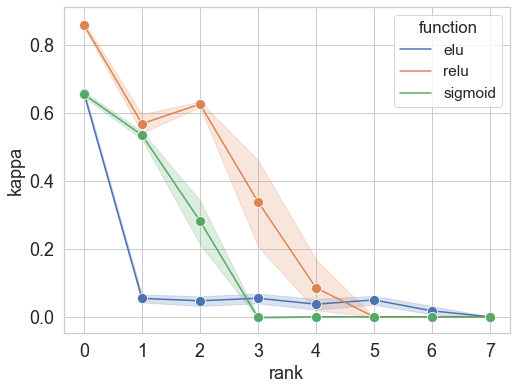

In [7]:
# script for datasets, activation functions, modulo, removing features

activations = [tf.nn.relu, tf.nn.elu, tf.nn.sigmoid]
variants = [True] # modulo

# train the model only once and then load
folder = "fcp_data"
for dataset in os.listdir(folder):
    
    if dataset != "appendicitis.arff.csv":
        continue
    
    output_file = "results_inc" + os.sep + dataset.replace(".arff.csv","") + "_results_inc.csv"
    header = "dataset,function,modulo,run,feature,composition,kappa"
    
    f = open(output_file, "w")
    f.write(header + "\n")
    f.flush()
    
    for function in activations:
        
        for mod in variants:
            
            for run in range(20):
                
                df, ohe_df, X, Y = load_dataset(os.path.join(folder,dataset))
                n_features = len(df.columns) - 1
                
                model = fit_model(X, Y, function=function)
#                 model.save(dataset.replace(".arff.csv","_") + function.__name__ + ".h5")

                Y_pred = model.predict(X, verbose=0)
                baseline = scorer(Y, Y_pred)
            
                # computing fcp
                comp_class = []
                for i, instance in enumerate(X):
                    compositions = fcp_matrix(instance, model, modulo=mod)
                    exp_class  = np.argmax(Y[i])
                    comp_class.append(compositions[-1][exp_class])
                comp = np.array(comp_class)

                # create dataframe of compositions
                ohe_features = ohe_df.columns[:-Y.shape[1]] # removing classes column names
                df_comp = pd.DataFrame(data=comp, columns=ohe_features)

                # aggregating ohe values for german the only dataset with cat features
                if dataset == "german_credit.arff.csv":
                    prefixes = df.columns[:-1] # removing 'class' from original list of columns
                    df_comp = aggregate(df_comp, prefixes)

                # reordering columns by abs mean value, first is highest composition
                df_comp = df_comp.reindex(df_comp.abs().mean().sort_values(ascending=False).index, axis=1)
                exclude = []

                # print in file
                f.write(dataset.replace(".arff.csv","")+",")
                f.write(function.__name__ + ",")
                f.write(str(mod) + ",")
                f.write(str(run) + ",")
                f.write("baseline,1.0," + str(baseline) + "\n")
                f.flush()

                for column in df_comp.columns:
                    exclude.append(column)

                    # accuracy after excluding the most important feature
                    df,_,X,Y = load_dataset(os.path.join(folder,dataset), exclude)

                    # predict with trained model
                    Y_pred = model.predict(X, verbose=0)
                    perf_feat = scorer(Y, Y_pred)
                    
                    f.write(dataset.replace(".arff.csv","")+",")
                    f.write(function.__name__ + ",")
                    f.write(str(mod) + ",")
                    f.write(str(run) + ",")
                    f.write(column + ",")
                    f.write(str(round(df_comp[column].abs().mean(),2)) + ",")
                    f.write(str(perf_feat) + "\n")
                    f.flush()

    f.close()

    results = pd.read_csv(output_file)
    results.sort_values(by=['function','run','composition'], ascending=[True, True, False], inplace=True, ignore_index=True)
    results['ranking'] = results.groupby(['function','run']).cumcount().astype(int)
    
    fig = plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax = sns.lineplot(data=results, x="ranking", y="kappa", hue="function", sort="False", ax=ax, marker='o', markersize=10)
    
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    plt.tick_params(axis='x', labelsize=18)
    plt.tick_params(axis='y', labelsize=18)
    plt.xlabel('rank', fontsize=18)
    plt.ylabel('kappa', fontsize=18)
    plt.savefig(output_file.replace(".csv",".pdf"), bbox_inches='tight')
    